# Naive Bayes


Bad key text.latex.unicode in file C:\Users\Badak\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file C:\Users\Badak\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file C:\Users\Badak\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/m

Panjang Corpus :  35912
Review Positif :  357
Review Negatif :  22022


ValueError: The number of FixedLocator locations (43), usually from a call to set_ticks, does not match the number of ticklabels (2).

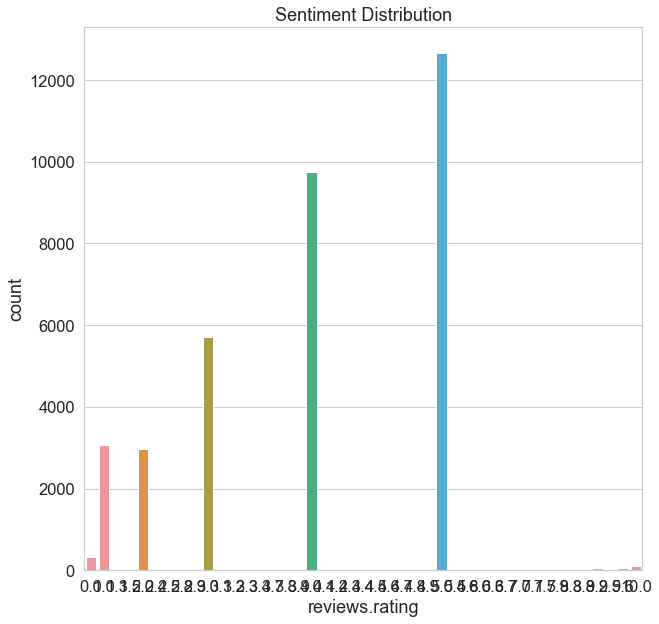

In [1]:
#!/usr/bin/env python
# coding: utf-8

# # NLP Project Sentiment Analysis

# ## Naive Bayes dan Laplace Smoothing

# In[1]:


#import lib
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import string
import re
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from bs4 import BeautifulSoup
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import time
from sklearn import svm
from sklearn.metrics import classification_report

get_ipython().run_line_magic('matplotlib', 'inline')

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 10, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)


# In[2]:


corpus = pd.read_csv('F:/KULIAH/Semester 7/PBA/PROYEK/7282_1.csv')


# In[3]:


print('Panjang Corpus : ',len(corpus))


# In[4]:


corpus.head()


# In[5]:


corpus.tail()


# In[6]:


review_positif = len([x for x in corpus['reviews.rating'] if x > 5 ])
review_negatif = len([x for x in corpus['reviews.rating'] if x < 5 ])
print('Review Positif : ',review_positif)
print('Review Negatif : ',review_negatif)


# In[7]:


#tampilkan distribusi sentiment
f = sns.countplot(x='reviews.rating', data=corpus)
f.set_title("Sentiment Distribution")
f.set_xticklabels(['Positive', 'Negative'])
plt.xlabel("");


# In[8]:


#remove punctuation
no_punctuations=[]
i=0
for word in corpus['reviews.text']:
    for punctuation in string.punctuation:
        word = word.replace(punctuation,"")
    for number in '1234567890':
        word = word.replace(number,"")
    corpus['reviews.text'][i] = word
    i = i+1
    
corpus['reviews.text'].head()


# In[9]:


#Membuat kelas tokenisasi
class Tokenizer:
    
    #clean html tag in review
    def clean(self, text):
        no_html = BeautifulSoup(text).get_text()
        clean = re.sub("[^a-z\s]+", " ", no_html, flags=re.IGNORECASE)
        return re.sub("(\s+)", " ", clean)
    
    #tokenizing corpus
    def tokenize(self, text):
        clean = self.clean(text).lower()
        stopwords_en = stopwords.words("english")
        return [w for w in re.split("\W+", clean) if not w in stopwords_en]
        #stem tokenized word
        porter.stem(w)


# In[10]:


#Multinomial NB kelas yang digunakan untuk menganalisis data
class MultinomialNaiveBayes:
    def _init_(self, classes, tokenizer):
        self.tokenizer = tokenizer
        self.classes = classes
      
    def group_by_class(self, X, y):
        data = dict()
        for c in self.classes:
            data[c] = X[np.where(y == c)]
        return data
           
    def fit(self, X, y):
        self.n_class_items = {}
        self.log_class_priors = {}
        self.word_counts = {}
        self.vocab = set()

        n = len(X)
        
        grouped_data = self.group_by_class(X, y)
        
        for c, data in grouped_data.items():
          self.n_class_items[c] = len(data)
          self.log_class_priors[c] = math.log(self.n_class_items[c] / n)
          self.word_counts[c] = defaultdict(lambda: 0)
          
          for text in data:
            counts = Counter(self.tokenizer.tokenize(text))
            for word, count in counts.items():
                if word not in self.vocab:
                    self.vocab.add(word)

                self.word_counts[c][word] += count
                
        return self
#fungsi laplace smoothing untuk menghilangkan kemungkinan nilai 0 pada data      
    def laplace_smoothing(self, word, text_class):
        num = self.word_counts[text_class][word] + 1
        denom = self.n_class_items[text_class] + len(self.vocab)
        return math.log(num / denom)
#fungsi prediksi terhadap kata yang ditokenisasi terhadap sentiment berdasarkan review      
    def predict(self, X):
        result = []
        for text in X:
          
          class_scores = {c: self.log_class_priors[c] for c in self.classes}

          words = set(self.tokenizer.tokenize(text))
          for word in words:
              if word not in self.vocab: continue

              for c in self.classes:
                
                log_w_given_c = self.laplace_smoothing(word, c)
                class_scores[c] += log_w_given_c
                
          result.append(max(class_scores, key=class_scores.get))

        return result


# In[11]:


#membuat X_train, X_test, y_train, y_test
X = corpus['reviews.text'].values
y = corpus['reviews.rating'].values
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)


# In[12]:


#memanggil fungsi MNB
MNB = MultinomialNaiveBayes(
    classes=np.unique(y), 
    tokenizer=Tokenizer()
).fit(X_train, y_train)


# In[13]:


#variabel baru untuk menyimpan hasil prediksi dari X_test
y_hat = MNB.predict(X_test)


# In[14]:


accuracy_score(y_test, y_hat)


# In[15]:


print(classification_report(y_test, y_hat))


# In[16]:


#membuat data dengan confusion matrix dari y_test dan y_hat yang menyimpan nilai prediksi dari review
cnf_matrix = confusion_matrix(y_test, y_hat)


# In[17]:


#menampilkan confusion matrix kedalam heatmap
class_names = ["Positive", "Negative"]
fig,ax = plt.subplots()

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('Actual sentiment')
plt.xlabel('Predicted sentiment');


# In[18]:


#menghitung akurasi dari mnb
from sklearn import metrics
print('Accuracy Score: ',metrics.accuracy_score(y_test,y_hat)*100,'%',sep='')